In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

In this notebook, you will learn how to load, explore, visualize, and pre-process a time-series dataset. The output of this notebook is a processed dataset that will be used in following notebooks to build a machine learning model.

### Dataset

[NY DATASET](https://console.cloud.google.com/marketplace/details/city-of-new-york/nyc-311?utm_campaign=CDR_kwe_aiml_time-series-forecasting_011521&utm_source=external&utm_medium=web): This dataset shows the complaints from different locations in NYC

### Objective

The goal is to predict 311 service requests from the City of New York. These non-emergency requests include noise complaints, street light issues, etc.


## Install packages and dependencies

Restarting the kernel may be required to use new packages.

In [2]:
%pip install -U statsmodels scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


**Note:** To restart the Kernel, navigate to Kernel > Restart Kernel... on the Jupyter menu.

### Import libraries and define constants

In [3]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.cloud import bigquery as bq


In [7]:
# Enter your project and region. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

PROJECT = 'optical-sight-307301' # REPLACE WITH YOUR PROJECT NAME 
REGION = 'us-west1-b' # REPLACE WITH YOUR REGION e.g. us-central1

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

In [73]:
target = 'complaint_type' # The variable you are predicting
target_description = 'Total Rides' # A description of the target variable
features = {'day_type': 'Day Type'} # Weekday = W, Saturday = A, Sunday/Holiday = U
ts_col = 'service_date' # The name of the column with the date field

processed_file = 'nyc_311_requests.csv' # Which file to save the results to

## Load data

In [46]:
# Import CSV file


sql = """
SELECT * FROM `bigquery-public-data.new_york_311.311_service_requests` LIMIT 1000
"""

client = bq.Client(project=PROJECT)
df = client.query(sql).to_dataframe()

df.head()


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pickup_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,15912542,2010-01-29 10:13:00+00:00,2010-01-30 12:00:00+00:00,DSNY,A - Canine Task Force Citywide,Dirty Conditions,E8 Canine Violation,Sidewalk,10455,None,...,None,None,None,None,None,None,None,40.814144,-73.919200,"(40.81414393010289, -73.9191997410658)"
1,15712570,2010-01-11 09:11:00+00:00,2010-01-06 00:05:00+00:00,DOT,Department of Transportation,Street Light Condition,Street Light Cycling,None,10455,None,...,None,None,None,None,None,None,None,40.815977,-73.911015,"(40.81597686698025, -73.9110146628044)"
2,15646991,2010-01-03 10:42:00+00:00,2010-01-08 15:55:00+00:00,DOT,Department of Transportation,Traffic Signal Condition,Veh Signal Head,None,10456,None,...,None,None,None,None,None,None,None,40.818061,-73.905000,"(40.81806080091984, -73.90500009055037)"
3,15646987,2010-01-03 06:00:00+00:00,2010-01-03 07:25:00+00:00,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10454,None,...,None,None,None,None,None,None,None,40.803594,-73.919780,"(40.803593615226994, -73.9197796424002)"
4,15646986,2010-01-03 06:00:00+00:00,2010-01-03 07:45:00+00:00,DOT,Department of Transportation,Traffic Signal Condition,Controller,None,10454,None,...,None,None,None,None,None,None,None,40.807703,-73.929546,"(40.80770336215764, -73.92954593122653)"


In [47]:
sql = """
SELECT
  DATE_TRUNC(DATE(created_date), month) as ds ,
    COUNT(unique_key) as y
FROM `bigquery-public-data.new_york_311.311_service_requests`
GROUP by ds ORDER BY ds asc
"""

monthly_df = client.query(sql).to_dataframe()

monthly_df.head()


,ds,y
0,2010-01-01,182117
1,2010-02-01,159489
2,2010-03-01,198639
3,2010-04-01,162854
4,2010-05-01,158039


In [57]:
# Drop duplicates
df = df[(df['created_date'] >= '2020-01-01')]

df = df.drop_duplicates()

In [58]:
# Sort by date

df = df.sort_index()

## Explore data

In [59]:
# Print the top 5 rows

df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pickup_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
236,45309844,2020-01-04 11:46:12+00:00,2020-02-20 09:27:05+00:00,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,PESTS,RESIDENTIAL BUILDING,10454,215F BROWN PLACE,...,None,None,None,None,None,None,None,40.807423,-73.920411,"(40.80742294500843, -73.92041078734978)"
238,45857494,2020-03-19 09:05:00+00:00,2020-03-20 12:00:00+00:00,DSNY,A - Bronx,Dirty Conditions,E3 Dirty Sidewalk,Sidewalk,10454,250 BROOK AVENUE,...,None,None,None,None,None,None,None,40.807834,-73.919041,"(40.80783370009161, -73.9190412358496)"
247,45429658,2020-01-20 15:16:12+00:00,2020-06-02 10:22:14+00:00,HPD,Department of Housing Preservation and Develop...,DOOR/WINDOW,DOOR,RESIDENTIAL BUILDING,10454,283 BROOK AVENUE,...,None,None,None,None,None,None,None,40.808662,-73.918592,"(40.80866229075476, -73.91859229764903)"
249,45399633,2020-01-16 17:42:26+00:00,2020-06-02 10:22:11+00:00,HPD,Department of Housing Preservation and Develop...,GENERAL,COOKING GAS,RESIDENTIAL BUILDING,10454,283 BROOK AVENUE,...,None,None,None,None,None,None,None,40.808662,-73.918592,"(40.80866229075476, -73.91859229764903)"
250,45403845,2020-01-16 19:14:11+00:00,2020-06-02 10:22:12+00:00,HPD,Department of Housing Preservation and Develop...,GENERAL,COOKING GAS,RESIDENTIAL BUILDING,10454,283 BROOK AVENUE,...,None,None,None,None,None,None,None,40.808662,-73.918592,"(40.80866229075476, -73.91859229764903)"


### TODO 1: Analyze the patterns

* Is complaint_type changing much over time?
* Is there a difference in complaint_type between the weekday and weekends?


In [60]:
# Initialize plotting

register_matplotlib_converters() # Addresses a warning
sns.set(rc={'figure.figsize':(16,4)})

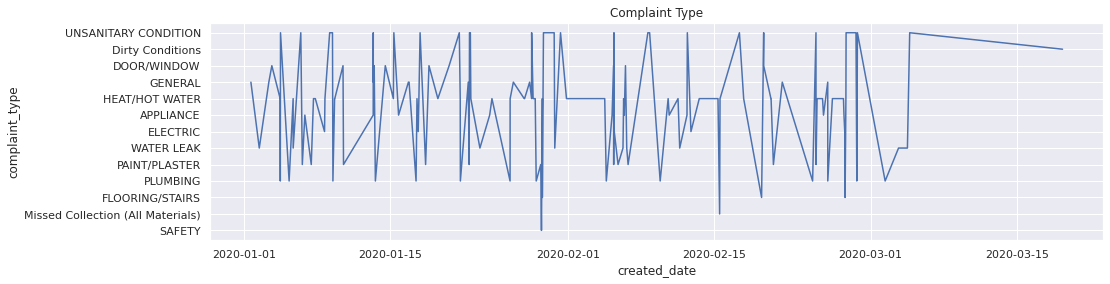

In [61]:
# Explore total rides over time

sns.lineplot(data=df, x=df.created_date, y=df[target]).set_title('Complaint Type')
fig = plt.show()

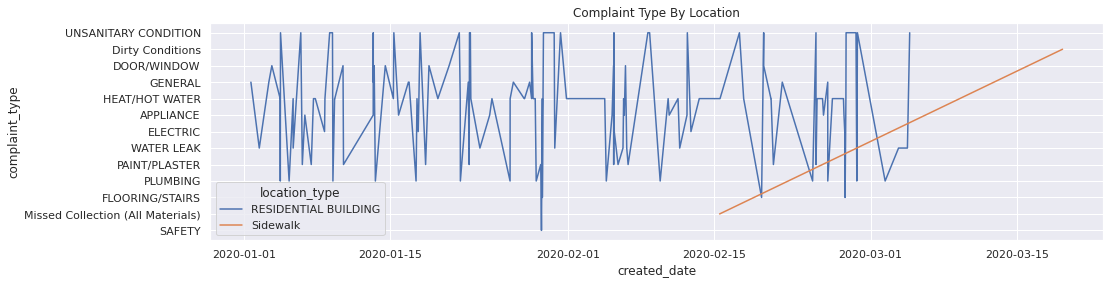

In [63]:
# Explore rides by day type: Weekday (W), Saturday (A), Sunday/Holiday (U)

sns.lineplot(data=df, x=df.created_date, y=df[target], hue=df['location_type']).set_title('Complaint Type By Location')
fig = plt.show()

### TODO 2: Review summary statistics

* How many records are in the dataset?
* What is the average # of riders per day?

In [64]:
df[target].describe()

count                142
unique                13
top       HEAT/HOT WATER
freq                  42
Name: complaint_type, dtype: object

### TODO 3: Explore seasonality

* Is there much difference between months?
* Can you extract the trend and seasonal pattern from the data?

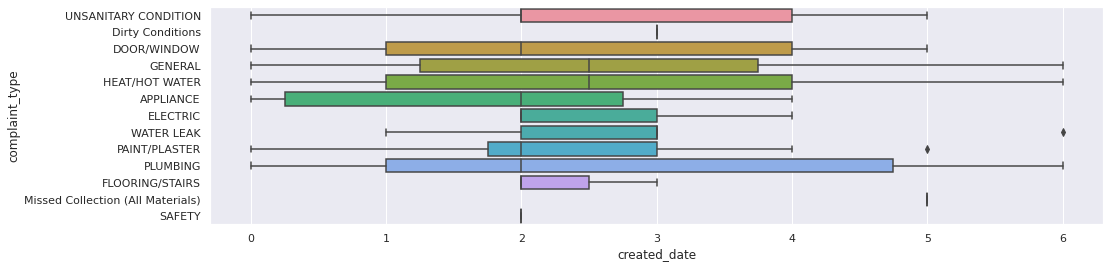

In [65]:
# Show the distribution of values for each day of the week in a boxplot:
# Min, 25th percentile, median, 75th percentile, max 

daysofweek = df.created_date.dt.dayofweek

fig = sns.boxplot(x=daysofweek, y=df[target])

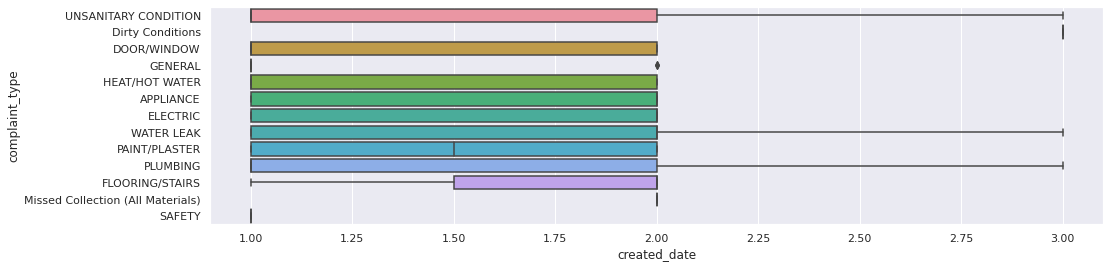

In [66]:
# Show the distribution of values for each month in a boxplot:

months = df.created_date.dt.month

fig = sns.boxplot(x=months, y=df[target])

### Auto-correlation

Next, we will create an auto-correlation plot, to show how correlated a time-series is with itself. Each point on the x-axis indicates the correlation at a given lag. The shaded area indicates the confidence interval.

Note that the correlation gradually decreases over time, but reflects weekly seasonality (e.g. `t-7` and `t-14` stand out).

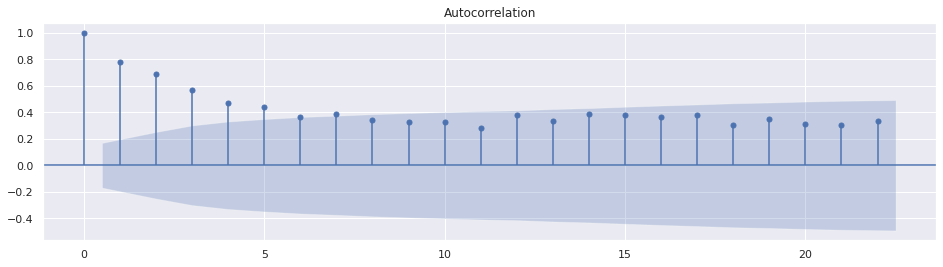

In [70]:
plot_acf(monthly_df["y"])

fig = plt.show()

## Export data

This will generate a CSV file, which you will use in the next labs of this quest.
Inspect the CSV file to see what the data looks like.

In [74]:
monthly_df[["ds","y"]].to_csv(processed_file, index=True, index_label=ts_col)

## Conclusion

You've successfully completed the exploration and visualization lab.
You've learned how to:
* Create a query that groups data into a time series
* Visualize data
* Decompose time series into trend and seasonal components